In [1]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
from collections import Counter

# max_vocab_size = 25000
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    token_counter = Counter(all_tokens)
#     print(token_counter)
    vocab = token_counter.keys()
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def read_data(fine_name):
    df = pd.read_csv(fine_name,sep='\t')
    return df

In [4]:
df_train = read_data("snli_train.tsv")
df_val = read_data("snli_val.tsv")

In [5]:
df_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [6]:
def tokenize(df):
    df['sentence1'] = df['sentence1'].apply(lambda x: [a.lower() for a in x.split(' ')])
    df['sentence2'] = df['sentence2'].apply(lambda x : [a.lower() for a in x.split(' ')])
    
    return df

In [7]:
df_train = tokenize(df_train)
df_val = tokenize(df_val)

In [8]:
df_train.head()

,sentence1,sentence2,label
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",neutral
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",entailment
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",neutral
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",contradiction
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",contradiction


In [9]:
words_to_load = 100000

import numpy as np

with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    words = {}
    idx2words = {}
    ordered_words = ['<pad>','<unk>']
    i = 2
    for line in f:
        if i-2 >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i, :] = np.asarray(s[1:])
        words[s[0]] = i
        idx2words[i] = s[0]
        ordered_words.append(s[0])
        i = i+1

In [10]:
max(words.values())

100001

In [11]:
words['<pad>'] = 0
words['<unk>'] = 1

In [12]:
idx2words[0] = "<pad>"
idx2words[1] = "<unk>"

In [13]:
# ordered_words.append("<pad>")
# ordered_words.append("<unk>")

In [14]:
# words
def apply_idz(x):
    temp = []
    for a in x:
        if a in ordered_words:
            temp.append(words[a])
        else:
            temp.append(1)
    return temp

In [15]:
def idize(df):
    df['sentence1_idz'] = df["sentence1"].apply(apply_idz)
    df['sentence2_idz'] = df["sentence2"].apply(apply_idz)
    return df

In [16]:
train_train = idize(df_train)

In [17]:
val_val = idize(df_val)

In [18]:
unk_vec = np.random.normal(size=300)
pad_vec = np.random.normal(size=300)

In [19]:
loaded_embeddings.shape

(100002, 300)

In [20]:
loaded_embeddings[0,:] = pad_vec
# np.insert(loaded_embeddings,0,pad_vec,axis=0)
loaded_embeddings[1,:] = unk_vec
# np.insert(loaded_embeddings,1,unk_vec,axis=0)

In [21]:
loaded_embeddings.shape

(100002, 300)

In [22]:
train_train.head()

,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",neutral,"[10, 803, 1831, 9, 10, 6266, 7168, 4389, 18, 1...","[10, 803, 1831, 2256, 4, 13986, 95, 4, 359, 5]"
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",entailment,"[10, 995, 16, 9767, 132, 4, 348, 425, 8, 87, 1...","[108, 68, 35, 425, 8, 205, 72, 5]"
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",neutral,"[805, 4, 1939, 3, 33, 85, 139, 10, 543, 403, 5]","[4, 543, 403, 16, 491, 7, 8418, 6, 8810]"
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",contradiction,"[10, 348, 9, 910, 11908, 6, 10, 885, 7168, 16,...","[10, 348, 16, 5212, 10, 1, 18, 4, 5657, 5]"
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",contradiction,"[310, 885, 3136, 442, 550, 18, 4809, 1827, 547...","[310, 3136, 35, 4722, 8, 41, 2194, 91, 596, 5]"


In [23]:
def encode_target(train_train):
    train_train['label'][train_train['label']=='neutral']=0
    train_train['label'][train_train['label']=='entailment']=1
    train_train['label'][train_train['label']=='contradiction']=2
    return train_train

In [24]:
train_train = encode_target(train_train)
val_val = encode_target(val_val)

In [25]:
train_train.head()

,sentence1,sentence2,label,sentence1_idz,sentence2_idz
0,"[a, young, girl, in, a, pink, shirt, sitting, ...","[a, young, girl, watching, the, sunset, over, ...",0,"[10, 803, 1831, 9, 10, 6266, 7168, 4389, 18, 1...","[10, 803, 1831, 2256, 4, 13986, 95, 4, 359, 5]"
1,"[a, woman, is, smiling, while, the, man, next,...","[two, people, are, next, to, each, other, .]",1,"[10, 995, 16, 9767, 132, 4, 348, 425, 8, 87, 1...","[108, 68, 35, 425, 8, 205, 72, 5]"
2,"[across, the, river, ,, you, can, see, a, larg...","[the, large, building, is, full, of, apartment...",0,"[805, 4, 1939, 3, 33, 85, 139, 10, 543, 403, 5]","[4, 543, 403, 16, 491, 7, 8418, 6, 8810]"
3,"[a, man, in, white, shorts, and, a, black, shi...","[a, man, is, riding, a, jetski, on, the, ocean...",2,"[10, 348, 9, 910, 11908, 6, 10, 885, 7168, 16,...","[10, 348, 16, 5212, 10, 1, 18, 4, 5657, 5]"
4,"[four, black, dogs, run, together, on, bright,...","[four, dogs, are, preparing, to, be, launched,...",2,"[310, 885, 3136, 442, 550, 18, 4809, 1827, 547...","[310, 3136, 35, 4722, 8, 41, 2194, 91, 596, 5]"


In [26]:
class SnliDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s1 = self.df.iloc[idx]['sentence1_idz']
        s2 = self.df.iloc[idx]['sentence2_idz']
        tar = self.df.iloc[idx]['label']
        len1 = len(s1)
        len2 = len(s2)
        return [s1,len1,s2,len2,tar]

In [27]:
def max_len(x):
    return len(x)
    

In [28]:
l1 = train_train['sentence1_idz'].apply(max_len)
l2 = train_train['sentence2_idz'].apply(max_len)
# MAX_LEN = max(l1+l2)
MAX_LEN = 25

In [29]:
def vocab_collate_func(batch):
    data_list_s1 = []
    data_list_s2 = []
    label_list = []
    length_list_s1 = []
    length_list_s2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_s1.append(datum[1])
        length_list_s2.append(datum[3])
    # padding
    for datum in batch:
        if datum[1]>MAX_LEN:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN - datum[1])),
                                mode="constant", constant_values=0)
        if datum[3]>MAX_LEN:
            padded_vec_s2 = np.array(datum[2])[:MAX_LEN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_LEN - datum[3])),
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_s1)
        data_list_s2.append(padded_vec_s2)
        
    return [torch.from_numpy(np.array(data_list_s1)), torch.LongTensor(length_list_s1), torch.from_numpy(np.array(data_list_s2)), torch.LongTensor(length_list_s2), torch.LongTensor(label_list)]

In [30]:
train_dataset = SnliDataset(train_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SnliDataset(val_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)



In [31]:
a = next(iter(train_loader))

In [35]:
class CNN(nn.Module):
    def __init__(self, emb_size, num_classes, vocab_size,n_feat,n_channel):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings), freeze=False)
        self.n_channel =n_channel
        self.conv1 = nn.Conv2d(1,n_feat,kernel_size=(5,300),stride=(1,1))
        self.conv2 = nn.Conv2d(n_feat,self.n_channel,kernel_size=(5,1),stride=(1,1))
        
        self.max1 = nn.MaxPool2d(kernel_size=(10,1))
        self.linear1 = nn.Linear(2*self.n_channel, 500)
        self.linear2 = nn.Linear(500,num_classes)
        self.dp1 = nn.Dropout(p=0.8)

    def forward(self, data_s1, length1, data_s2, length2):

        embed1 = torch.unsqueeze(self.embedding(data_s1),dim=1)
        embed2 = torch.unsqueeze(self.embedding(data_s2),dim=1)
        
        out1 = F.relu(self.conv1(embed1))
        out2 = F.relu(self.conv1(embed2))
        
        out1 = F.relu(self.conv2(out1))
        out2 = F.relu(self.conv2(out2))

#         print("out",out1.size())
        mout1 = self.max1(out1)
        mout2 = self.max1(out2)
#         print("mout",mout1.size())
        
        sum1 = torch.squeeze(torch.sum(mout1,dim=2))
        sum2 = torch.squeeze(torch.sum(mout2,dim=2))
#         print("sum",sum1.size())
#         combined_out = torch.squeeze(torch.cat([mout1, mout2], dim=1))
        combined_out = torch.cat([sum1,sum2],dim=1)
#         print("comb",combined_out.size())
        
        logits = F.relu(self.linear1(combined_out))
        res = self.linear2(logits)
        
        return res



In [36]:
dataloaders = [train_loader, val_loader]

In [37]:
def training(model,criterion, optimizer, name, num_epochs):
    mask_l = [True]*100002
    mask_l[1]=False
    zz = torch.zeros((1,300)).cuda()
    best_loss = np.inf
    best_acc = 0
    loss_hist = {'train':[],'validate':[]}
    acc_hist = {'train':[],'validate':[]}
    for i in range(num_epochs):
        for enu,phase in enumerate(['train', 'validate']):
            running_loss = 0
            running_total = 0
            correct = 0
            total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
            for (data1, length1, data2, length2, labels) in dataloaders[enu]:
#                 data_batch1, length_batch1, data_batch2, len_batch2, label_batch = data1, length1, data2, length2, labels
                data_batch1, len_batch1, data_batch2, len_batch2, label_batch = data1.cuda(), length1.cuda(), data2.cuda(), length2.cuda(), labels.cuda()


                optimizer.zero_grad()
                outputs = model(data_batch1, len_batch1, data_batch2, len_batch2)
                loss = criterion(outputs, label_batch)
                if phase=='train':
                    loss.backward()
#                     model.embedding.weight.grad[mask_l,:] = zz
                    optimizer.step()
                N = labels.size(0)
                
                outputs = F.softmax(outputs, dim=1)
                predicted = outputs.max(1, keepdim=True)[1]
#                 print(type(predicted))
                total += labels.size(0)
                correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
                running_loss += loss.data[0] * N
                running_total += N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            accuracy = 100 * correct / total
            acc_hist[phase].append(accuracy)
            print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, accuracy: {:.4f}'\
                      .format(i,phase,epoch_loss, accuracy))
        if phase == 'validate' and best_acc < accuracy:
            best_loss = epoch_loss
            best_acc = accuracy
            torch.save(model,name)
    print('Best val dice loss: {:4f}, Best Accuracy: {:4f}'.format(best_loss,best_acc))
    return model, loss_hist,acc_hist

## kernel=5, feature_maps=500, n_channels2=100

In [42]:
model = CNN(300, 3, words_to_load+2,500,100).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn1",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 500, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(500, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Phase: train, epoch loss: 0.7758, accuracy: 65.7720
Epoch: 1, Phase: validate, epoch loss: 0.8397, accuracy: 61.4000
Epoch: 2, Phase: train, epoch loss: 0.6853, accuracy: 70.7790
Epoch: 2, Phase: validate, epoch loss: 0.8390, accuracy: 63.3000
Epoch: 3, Phase: train, epoch loss: 0.5807, accuracy: 75.8770
Epoch: 3, Phase: validate, epoch loss: 0.8614, accuracy: 63.2000
Epoch: 4, Phase: train, epoch loss: 0.4606, accuracy: 81.6670
Epoch: 4, Phase: validate, epoch loss: 0.9784, accuracy: 62.7000
Epoch: 5, Phase: train, epoch loss: 0.3491, accuracy: 86.5630
Epoch: 5, Phase: validate, epoch loss: 1.1837, accuracy: 64.1000
Epoch: 6, Phase: train, epoch loss: 0.2654, accuracy: 89.9990
Epoch: 6, Phase: validate, epoch loss: 1.4579, accuracy: 63.1000
Epoch: 7, Phase: train, epoch loss: 0.2043, accuracy: 92.4580
Epoch: 7, Phase: validate, epoch loss: 1.6670, accuracy: 63.0000
Epoch: 8, Phase: train, epoch loss: 0.1672, accuracy: 93.8100
Epoch: 8, Phase: validate, epoch loss: 1.7834, ac

31103203


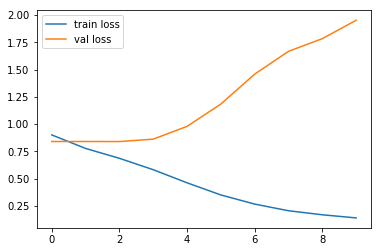

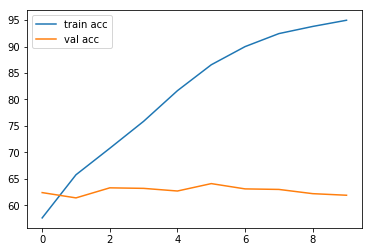

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
print(count_parameters(model))
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=300, n_channels2=100

In [44]:
model = CNN(300, 3, words_to_load+2,300,100).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn2",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 300, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(300, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9000, accuracy: 57.6840
Epoch: 0, Phase: validate, epoch loss: 0.8591, accuracy: 59.2000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7762, accuracy: 65.7780
Epoch: 1, Phase: validate, epoch loss: 0.8147, accuracy: 64.5000
Epoch: 2, Phase: train, epoch loss: 0.6870, accuracy: 70.5770
Epoch: 2, Phase: validate, epoch loss: 0.7996, accuracy: 64.6000
Epoch: 3, Phase: train, epoch loss: 0.5890, accuracy: 75.6290
Epoch: 3, Phase: validate, epoch loss: 0.8586, accuracy: 63.8000
Epoch: 4, Phase: train, epoch loss: 0.4801, accuracy: 80.5780
Epoch: 4, Phase: validate, epoch loss: 0.9348, accuracy: 62.4000
Epoch: 5, Phase: train, epoch loss: 0.3760, accuracy: 85.2520
Epoch: 5, Phase: validate, epoch loss: 1.1406, accuracy: 63.0000
Epoch: 6, Phase: train, epoch loss: 0.2964, accuracy: 88.6390
Epoch: 6, Phase: validate, epoch loss: 1.2587, accuracy: 61.7000
Epoch: 7, Phase: train, epoch loss: 0.2328, accuracy: 91.2130
Epoch: 7, Phase: validate, epoch loss: 1.4701, accuracy: 60.9000
Epoch: 8, Phase: train, epoch loss: 0.1917, accuracy: 92.8990
Epoch: 8, Phase: validate, epoch loss: 1.6298, ac

30703003


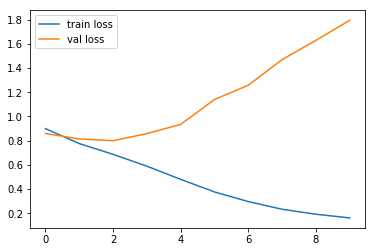

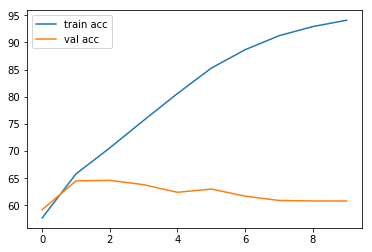

In [45]:
print(count_parameters(model))
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=200, n_channels2=100

In [46]:
model = CNN(300, 3, words_to_load+2,200,100).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn2",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9020, accuracy: 57.2890
Epoch: 0, Phase: validate, epoch loss: 0.8233, accuracy: 62.8000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7827, accuracy: 65.2270
Epoch: 1, Phase: validate, epoch loss: 0.8020, accuracy: 64.1000
Epoch: 2, Phase: train, epoch loss: 0.7027, accuracy: 69.8270
Epoch: 2, Phase: validate, epoch loss: 0.8134, accuracy: 65.6000
Epoch: 3, Phase: train, epoch loss: 0.6178, accuracy: 74.2470
Epoch: 3, Phase: validate, epoch loss: 0.8433, accuracy: 63.2000
Epoch: 4, Phase: train, epoch loss: 0.5248, accuracy: 78.5590
Epoch: 4, Phase: validate, epoch loss: 0.9446, accuracy: 64.0000
Epoch: 5, Phase: train, epoch loss: 0.4294, accuracy: 83.0010
Epoch: 5, Phase: validate, epoch loss: 1.0753, accuracy: 64.2000
Epoch: 6, Phase: train, epoch loss: 0.3460, accuracy: 86.5910
Epoch: 6, Phase: validate, epoch loss: 1.1973, accuracy: 61.9000
Epoch: 7, Phase: train, epoch loss: 0.2800, accuracy: 89.2520
Epoch: 7, Phase: validate, epoch loss: 1.4307, accuracy: 62.2000
Epoch: 8, Phase: train, epoch loss: 0.2271, accuracy: 91.3680
Epoch: 8, Phase: validate, epoch loss: 1.6567, ac

In [47]:
count_parameters(model)

30502903

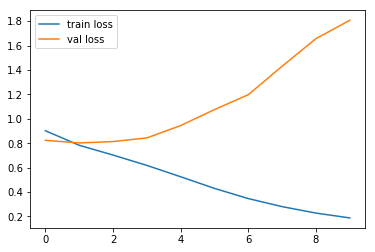

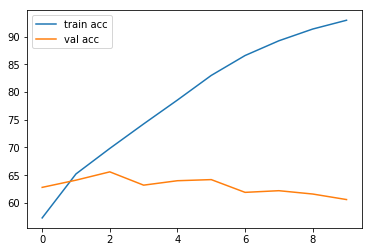

In [48]:
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=600, n_channels2=100

In [49]:
model = CNN(300, 3, words_to_load+2,600,100).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn4",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 600, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(600, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.8984, accuracy: 57.6820
Epoch: 0, Phase: validate, epoch loss: 0.8606, accuracy: 60.5000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7743, accuracy: 65.8170
Epoch: 1, Phase: validate, epoch loss: 0.8212, accuracy: 64.1000
Epoch: 2, Phase: train, epoch loss: 0.6853, accuracy: 70.6450
Epoch: 2, Phase: validate, epoch loss: 0.8291, accuracy: 63.7000
Epoch: 3, Phase: train, epoch loss: 0.5789, accuracy: 75.9340
Epoch: 3, Phase: validate, epoch loss: 0.8797, accuracy: 62.8000
Epoch: 4, Phase: train, epoch loss: 0.4572, accuracy: 81.7150
Epoch: 4, Phase: validate, epoch loss: 0.9621, accuracy: 63.8000
Epoch: 5, Phase: train, epoch loss: 0.3441, accuracy: 86.6900
Epoch: 5, Phase: validate, epoch loss: 1.1767, accuracy: 63.6000
Epoch: 6, Phase: train, epoch loss: 0.2621, accuracy: 90.0300
Epoch: 6, Phase: validate, epoch loss: 1.5239, accuracy: 62.8000
Epoch: 7, Phase: train, epoch loss: 0.2046, accuracy: 92.4250
Epoch: 7, Phase: validate, epoch loss: 1.5853, accuracy: 63.2000
Epoch: 8, Phase: train, epoch loss: 0.1669, accuracy: 93.7690
Epoch: 8, Phase: validate, epoch loss: 1.6922, ac

31303303


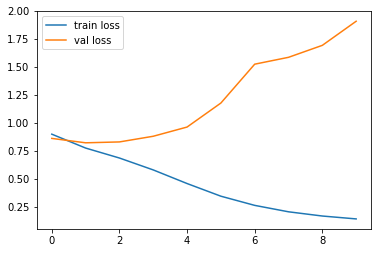

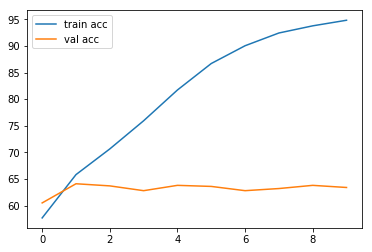

In [50]:
print(count_parameters(model))
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=300, n_channels2=200

In [51]:
model = CNN(300, 3, words_to_load+2,300, 200).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn5",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 300, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(300, 200, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.8974, accuracy: 57.7920
Epoch: 0, Phase: validate, epoch loss: 0.8472, accuracy: 61.6000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7741, accuracy: 65.8050
Epoch: 1, Phase: validate, epoch loss: 0.8183, accuracy: 63.3000
Epoch: 2, Phase: train, epoch loss: 0.6864, accuracy: 70.6400
Epoch: 2, Phase: validate, epoch loss: 0.8154, accuracy: 64.0000
Epoch: 3, Phase: train, epoch loss: 0.5842, accuracy: 75.5520
Epoch: 3, Phase: validate, epoch loss: 0.8899, accuracy: 63.9000
Epoch: 4, Phase: train, epoch loss: 0.4696, accuracy: 81.0720
Epoch: 4, Phase: validate, epoch loss: 1.0037, accuracy: 61.3000
Epoch: 5, Phase: train, epoch loss: 0.3607, accuracy: 85.6920
Epoch: 5, Phase: validate, epoch loss: 1.2337, accuracy: 61.3000
Epoch: 6, Phase: train, epoch loss: 0.2762, accuracy: 89.4330
Epoch: 6, Phase: validate, epoch loss: 1.4165, accuracy: 62.3000
Epoch: 7, Phase: train, epoch loss: 0.2185, accuracy: 91.6510
Epoch: 7, Phase: validate, epoch loss: 1.6499, accuracy: 61.2000
Epoch: 8, Phase: train, epoch loss: 0.1746, accuracy: 93.5000
Epoch: 8, Phase: validate, epoch loss: 1.8992, ac

30953103


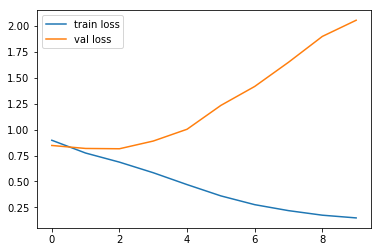

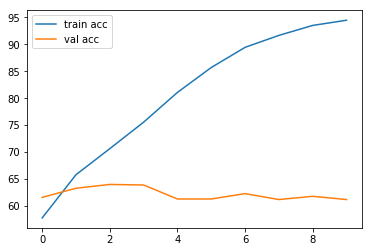

In [52]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=300, n_channels2=300

In [53]:
model = CNN(300, 3, words_to_load+2,300, 300).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn6",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 300, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(300, 300, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=600, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.8959, accuracy: 57.9550
Epoch: 0, Phase: validate, epoch loss: 0.8490, accuracy: 61.2000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7720, accuracy: 65.9210
Epoch: 1, Phase: validate, epoch loss: 0.8090, accuracy: 65.4000
Epoch: 2, Phase: train, epoch loss: 0.6787, accuracy: 70.9610
Epoch: 2, Phase: validate, epoch loss: 0.8142, accuracy: 65.0000
Epoch: 3, Phase: train, epoch loss: 0.5711, accuracy: 76.2690
Epoch: 3, Phase: validate, epoch loss: 0.9211, accuracy: 63.4000
Epoch: 4, Phase: train, epoch loss: 0.4494, accuracy: 81.9270
Epoch: 4, Phase: validate, epoch loss: 1.0465, accuracy: 62.5000
Epoch: 5, Phase: train, epoch loss: 0.3365, accuracy: 86.8230
Epoch: 5, Phase: validate, epoch loss: 1.3507, accuracy: 60.6000
Epoch: 6, Phase: train, epoch loss: 0.2555, accuracy: 90.2050
Epoch: 6, Phase: validate, epoch loss: 1.5412, accuracy: 62.2000
Epoch: 7, Phase: train, epoch loss: 0.2035, accuracy: 92.2880
Epoch: 7, Phase: validate, epoch loss: 1.9435, accuracy: 59.8000
Epoch: 8, Phase: train, epoch loss: 0.1638, accuracy: 93.8430
Epoch: 8, Phase: validate, epoch loss: 2.1046, ac

31203203


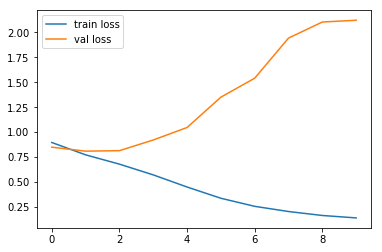

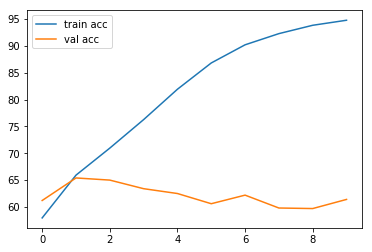

In [54]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=200, n_channels2=100, weight_decay = 0.00001

In [55]:
model = CNN(300, 3, words_to_load+2,200,100).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.00001)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn7",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.8993, accuracy: 57.5680
Epoch: 0, Phase: validate, epoch loss: 0.8535, accuracy: 61.5000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7890, accuracy: 64.9610
Epoch: 1, Phase: validate, epoch loss: 0.8068, accuracy: 62.7000
Epoch: 2, Phase: train, epoch loss: 0.7287, accuracy: 68.4110
Epoch: 2, Phase: validate, epoch loss: 0.8176, accuracy: 62.7000
Epoch: 3, Phase: train, epoch loss: 0.6773, accuracy: 71.1970
Epoch: 3, Phase: validate, epoch loss: 0.8141, accuracy: 63.5000
Epoch: 4, Phase: train, epoch loss: 0.6256, accuracy: 73.5930
Epoch: 4, Phase: validate, epoch loss: 0.8187, accuracy: 65.9000
Epoch: 5, Phase: train, epoch loss: 0.5707, accuracy: 76.3720
Epoch: 5, Phase: validate, epoch loss: 0.8847, accuracy: 65.1000
Epoch: 6, Phase: train, epoch loss: 0.5126, accuracy: 78.9680
Epoch: 6, Phase: validate, epoch loss: 0.8947, accuracy: 64.0000
Epoch: 7, Phase: train, epoch loss: 0.4517, accuracy: 81.8360
Epoch: 7, Phase: validate, epoch loss: 1.0152, accuracy: 63.9000
Epoch: 8, Phase: train, epoch loss: 0.3966, accuracy: 84.1800
Epoch: 8, Phase: validate, epoch loss: 1.1075, ac

## kernel=5, feature_maps=300, n_channels2=300,weight_decay=0.00001

In [56]:
model = CNN(300, 3, words_to_load+2,300, 300).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005,weight_decay=0.00001)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn6",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 300, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(300, 300, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=600, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.8964, accuracy: 57.8500
Epoch: 0, Phase: validate, epoch loss: 0.8415, accuracy: 61.9000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7835, accuracy: 65.4670
Epoch: 1, Phase: validate, epoch loss: 0.8044, accuracy: 65.7000
Epoch: 2, Phase: train, epoch loss: 0.7237, accuracy: 68.6620
Epoch: 2, Phase: validate, epoch loss: 0.7943, accuracy: 64.9000
Epoch: 3, Phase: train, epoch loss: 0.6686, accuracy: 71.5950
Epoch: 3, Phase: validate, epoch loss: 0.8158, accuracy: 64.4000
Epoch: 4, Phase: train, epoch loss: 0.6092, accuracy: 74.4680
Epoch: 4, Phase: validate, epoch loss: 0.8402, accuracy: 65.1000
Epoch: 5, Phase: train, epoch loss: 0.5427, accuracy: 77.8100
Epoch: 5, Phase: validate, epoch loss: 0.8706, accuracy: 64.2000
Epoch: 6, Phase: train, epoch loss: 0.4714, accuracy: 80.9430
Epoch: 6, Phase: validate, epoch loss: 0.9678, accuracy: 63.2000
Epoch: 7, Phase: train, epoch loss: 0.4024, accuracy: 83.9790
Epoch: 7, Phase: validate, epoch loss: 1.1284, accuracy: 61.3000
Epoch: 8, Phase: train, epoch loss: 0.3395, accuracy: 86.6310
Epoch: 8, Phase: validate, epoch loss: 1.1862, ac

31203203


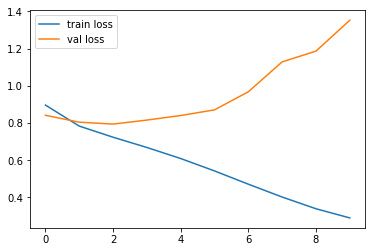

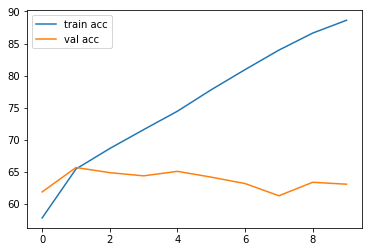

In [57]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=5, feature_maps=200, n_channels2=100,weight_decay=0.00005

In [58]:
model = CNN(300, 3, words_to_load+2,200,100).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.00005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn8",10)

CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9086, accuracy: 57.0860
Epoch: 0, Phase: validate, epoch loss: 0.8498, accuracy: 61.3000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8095, accuracy: 63.6240
Epoch: 1, Phase: validate, epoch loss: 0.8248, accuracy: 61.2000
Epoch: 2, Phase: train, epoch loss: 0.7661, accuracy: 66.1390
Epoch: 2, Phase: validate, epoch loss: 0.7960, accuracy: 65.2000
Epoch: 3, Phase: train, epoch loss: 0.7370, accuracy: 67.8730
Epoch: 3, Phase: validate, epoch loss: 0.8063, accuracy: 65.2000
Epoch: 4, Phase: train, epoch loss: 0.7095, accuracy: 69.3570
Epoch: 4, Phase: validate, epoch loss: 0.8215, accuracy: 64.5000
Epoch: 5, Phase: train, epoch loss: 0.6796, accuracy: 70.8020
Epoch: 5, Phase: validate, epoch loss: 0.8504, accuracy: 62.8000
Epoch: 6, Phase: train, epoch loss: 0.6493, accuracy: 72.4850
Epoch: 6, Phase: validate, epoch loss: 0.8103, accuracy: 65.1000
Epoch: 7, Phase: train, epoch loss: 0.6153, accuracy: 74.2300
Epoch: 7, Phase: validate, epoch loss: 0.8270, accuracy: 63.1000
Epoch: 9, Phase: train, epoch loss: 0.5366, accuracy: 77.8870
Epoch: 9, Phase: validate, epoch loss: 0.8519, ac

30502903


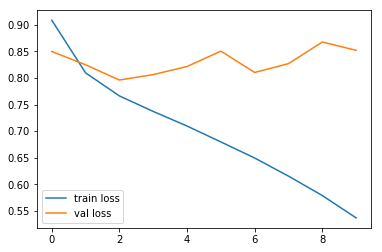

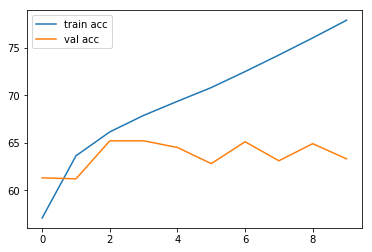

In [59]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

In [64]:
class CNN2(nn.Module):
    def __init__(self, emb_size, num_classes, vocab_size,n_feat,n_channel,dp):
        super(CNN2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings), freeze=False)
        self.n_channel =n_channel
        self.conv1 = nn.Conv2d(1,n_feat,kernel_size=(3,300),stride=(1,1))
        self.conv2 = nn.Conv2d(n_feat,self.n_channel,kernel_size=(5,1),stride=(1,1))
        
        self.max1 = nn.MaxPool2d(kernel_size=(10,1))
        self.linear1 = nn.Linear(2*self.n_channel, 500)
        self.linear2 = nn.Linear(500,num_classes)
        self.dp1 = nn.Dropout(p=dp)

    def forward(self, data_s1, length1, data_s2, length2):

        embed1 = torch.unsqueeze(self.embedding(data_s1),dim=1)
        embed2 = torch.unsqueeze(self.embedding(data_s2),dim=1)
        
        out1 = F.relu(self.conv1(embed1))
        out2 = F.relu(self.conv1(embed2))
        
        out1 = F.relu(self.conv2(out1))
        out2 = F.relu(self.conv2(out2))

#         print("out",out1.size())
        mout1 = self.max1(out1)
        mout2 = self.max1(out2)
#         print("mout",mout1.size())
        
        sum1 = torch.squeeze(torch.sum(mout1,dim=2))
        sum2 = torch.squeeze(torch.sum(mout2,dim=2))
#         print("sum",sum1.size())
#         combined_out = torch.squeeze(torch.cat([mout1, mout2], dim=1))
        combined_out = torch.cat([sum1,sum2],dim=1)
#         print("comb",combined_out.size())
        
        logits = F.relu(self.linear1(self.dp1(combined_out)))
        res = self.linear2(logits)
        
        return res




## kernel=3, feature_maps=200, n_channels2=100,weight_decay=0.00001

In [62]:
model = CNN2(300, 3, words_to_load+2,200,100,0).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.00001)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn9",10)

CNN2(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.8)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.8961, accuracy: 57.7650
Epoch: 0, Phase: validate, epoch loss: 0.8536, accuracy: 61.4000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7830, accuracy: 65.4830
Epoch: 1, Phase: validate, epoch loss: 0.8036, accuracy: 65.2000
Epoch: 2, Phase: train, epoch loss: 0.7228, accuracy: 68.8320
Epoch: 2, Phase: validate, epoch loss: 0.7891, accuracy: 66.2000
Epoch: 3, Phase: train, epoch loss: 0.6717, accuracy: 71.5790
Epoch: 3, Phase: validate, epoch loss: 0.7897, accuracy: 65.4000
Epoch: 4, Phase: train, epoch loss: 0.6253, accuracy: 73.8680
Epoch: 4, Phase: validate, epoch loss: 0.8080, accuracy: 64.6000
Epoch: 5, Phase: train, epoch loss: 0.5807, accuracy: 76.1470
Epoch: 5, Phase: validate, epoch loss: 0.8020, accuracy: 66.8000
Epoch: 6, Phase: train, epoch loss: 0.5317, accuracy: 78.3650
Epoch: 6, Phase: validate, epoch loss: 0.8531, accuracy: 64.9000
Epoch: 7, Phase: train, epoch loss: 0.4809, accuracy: 80.6600
Epoch: 7, Phase: validate, epoch loss: 0.9020, accuracy: 65.5000
Epoch: 8, Phase: train, epoch loss: 0.4285, accuracy: 82.9440
Epoch: 8, Phase: validate, epoch loss: 1.0134, ac

30382903


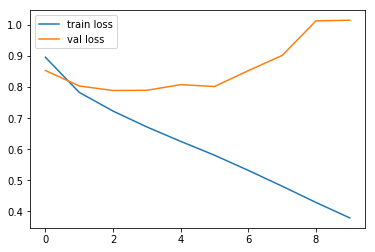

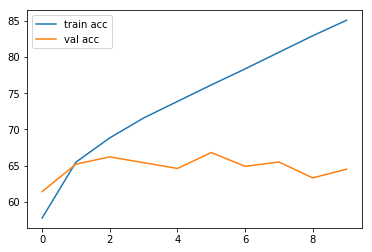

In [63]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=3, feature_maps=200, n_channels2=100,drop_out =0.5

In [65]:
model = CNN2(300, 3, words_to_load+2,200,100,0.5).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn10",10)

CNN2(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.5)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9322, accuracy: 55.5280
Epoch: 0, Phase: validate, epoch loss: 0.8646, accuracy: 62.8000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8249, accuracy: 63.0950
Epoch: 1, Phase: validate, epoch loss: 0.8173, accuracy: 64.3000
Epoch: 2, Phase: train, epoch loss: 0.7724, accuracy: 66.1070
Epoch: 2, Phase: validate, epoch loss: 0.8192, accuracy: 63.6000
Epoch: 3, Phase: train, epoch loss: 0.7302, accuracy: 68.4840
Epoch: 3, Phase: validate, epoch loss: 0.7998, accuracy: 65.9000
Epoch: 4, Phase: train, epoch loss: 0.6909, accuracy: 70.6390
Epoch: 4, Phase: validate, epoch loss: 0.7926, accuracy: 66.1000
Epoch: 5, Phase: train, epoch loss: 0.6517, accuracy: 72.5370
Epoch: 5, Phase: validate, epoch loss: 0.8053, accuracy: 65.1000
Epoch: 6, Phase: train, epoch loss: 0.6125, accuracy: 74.4340
Epoch: 6, Phase: validate, epoch loss: 0.8094, accuracy: 64.2000
Epoch: 7, Phase: train, epoch loss: 0.5772, accuracy: 76.2300
Epoch: 7, Phase: validate, epoch loss: 0.8225, accuracy: 65.7000
Epoch: 8, Phase: train, epoch loss: 0.5404, accuracy: 77.9610
Epoch: 8, Phase: validate, epoch loss: 0.8553, ac

30382903


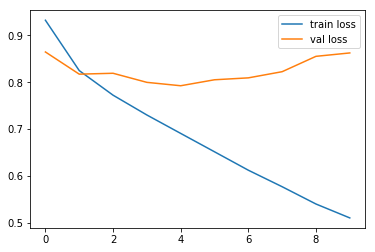

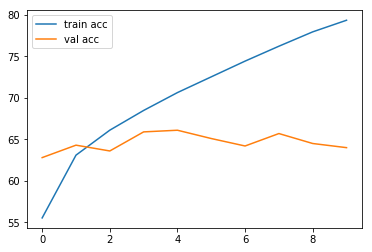

In [66]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=3, feature_maps=200, n_channels2=100,drop_out =0.3

In [67]:
model = CNN2(300, 3, words_to_load+2,200,100,0.3).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn11",10)

CNN2(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.3)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9141, accuracy: 56.7140
Epoch: 0, Phase: validate, epoch loss: 0.8577, accuracy: 62.0000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8055, accuracy: 64.3590
Epoch: 1, Phase: validate, epoch loss: 0.8211, accuracy: 64.6000
Epoch: 2, Phase: train, epoch loss: 0.7453, accuracy: 67.7470
Epoch: 2, Phase: validate, epoch loss: 0.8001, accuracy: 65.7000
Epoch: 3, Phase: train, epoch loss: 0.6939, accuracy: 70.4650
Epoch: 3, Phase: validate, epoch loss: 0.7928, accuracy: 67.2000
Epoch: 4, Phase: train, epoch loss: 0.6443, accuracy: 72.9160
Epoch: 4, Phase: validate, epoch loss: 0.8277, accuracy: 64.3000
Epoch: 5, Phase: train, epoch loss: 0.5963, accuracy: 75.1910
Epoch: 5, Phase: validate, epoch loss: 0.8313, accuracy: 63.5000
Epoch: 6, Phase: train, epoch loss: 0.5490, accuracy: 77.7080
Epoch: 6, Phase: validate, epoch loss: 0.8443, accuracy: 66.0000
Epoch: 7, Phase: train, epoch loss: 0.5024, accuracy: 79.6110
Epoch: 7, Phase: validate, epoch loss: 0.9358, accuracy: 66.6000
Epoch: 8, Phase: train, epoch loss: 0.4622, accuracy: 81.3440
Epoch: 8, Phase: validate, epoch loss: 0.9548, ac

30382903


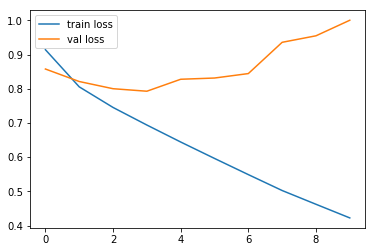

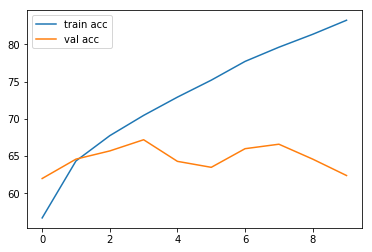

In [68]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=3, feature_maps=200, n_channels2=100,drop_out =0.2

In [69]:
model = CNN2(300, 3, words_to_load+2,200,100,0.2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn12",10)

CNN2(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.2)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9058, accuracy: 57.2590
Epoch: 0, Phase: validate, epoch loss: 0.8478, accuracy: 61.3000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7941, accuracy: 64.8270
Epoch: 1, Phase: validate, epoch loss: 0.8308, accuracy: 61.4000
Epoch: 2, Phase: train, epoch loss: 0.7300, accuracy: 68.2340
Epoch: 2, Phase: validate, epoch loss: 0.8133, accuracy: 64.2000
Epoch: 3, Phase: train, epoch loss: 0.6753, accuracy: 71.2910
Epoch: 3, Phase: validate, epoch loss: 0.8113, accuracy: 64.8000
Epoch: 4, Phase: train, epoch loss: 0.6184, accuracy: 74.1370
Epoch: 4, Phase: validate, epoch loss: 0.8392, accuracy: 65.0000
Epoch: 5, Phase: train, epoch loss: 0.5615, accuracy: 76.8140
Epoch: 5, Phase: validate, epoch loss: 0.8887, accuracy: 64.9000
Epoch: 6, Phase: train, epoch loss: 0.5084, accuracy: 79.4050
Epoch: 6, Phase: validate, epoch loss: 0.9379, accuracy: 63.8000
Epoch: 7, Phase: train, epoch loss: 0.4586, accuracy: 81.6120
Epoch: 7, Phase: validate, epoch loss: 0.9744, accuracy: 62.7000
Epoch: 8, Phase: train, epoch loss: 0.4166, accuracy: 83.2900
Epoch: 8, Phase: validate, epoch loss: 1.0359, ac

30382903


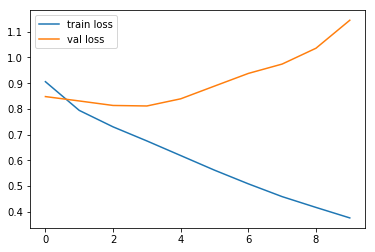

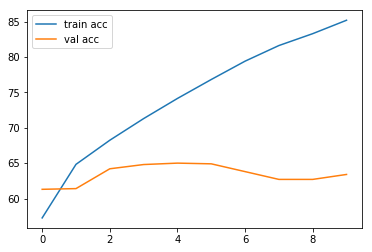

In [70]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

In [71]:
class CNN3(nn.Module):
    def __init__(self, emb_size, num_classes, vocab_size,n_feat,n_channel,dp):
        super(CNN3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings), freeze=False)
        self.n_channel =n_channel
        self.conv1 = nn.Conv2d(1,n_feat,kernel_size=(7,300),stride=(1,1))
        self.conv2 = nn.Conv2d(n_feat,self.n_channel,kernel_size=(5,1),stride=(1,1))
        
        self.max1 = nn.MaxPool2d(kernel_size=(10,1))
        self.linear1 = nn.Linear(2*self.n_channel, 500)
        self.linear2 = nn.Linear(500,num_classes)
        self.dp1 = nn.Dropout(p=dp)

    def forward(self, data_s1, length1, data_s2, length2):

        embed1 = torch.unsqueeze(self.embedding(data_s1),dim=1)
        embed2 = torch.unsqueeze(self.embedding(data_s2),dim=1)
        
        out1 = F.relu(self.conv1(embed1))
        out2 = F.relu(self.conv1(embed2))
        
        out1 = F.relu(self.conv2(out1))
        out2 = F.relu(self.conv2(out2))

#         print("out",out1.size())
        mout1 = self.max1(out1)
        mout2 = self.max1(out2)
#         print("mout",mout1.size())
        
        sum1 = torch.squeeze(torch.sum(mout1,dim=2))
        sum2 = torch.squeeze(torch.sum(mout2,dim=2))
#         print("sum",sum1.size())
#         combined_out = torch.squeeze(torch.cat([mout1, mout2], dim=1))
        combined_out = torch.cat([sum1,sum2],dim=1)
#         print("comb",combined_out.size())
        
        logits = F.relu(self.linear1(self.dp1(combined_out)))
        res = self.linear2(logits)
        
        return res





## kernel=7, feature_maps=200, n_channels2=100,drop_out =0.3

In [76]:
model = CNN3(300, 3, words_to_load+2,200,100,0.3).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn13",10)

CNN3(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(7, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.3)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9199, accuracy: 56.2680
Epoch: 0, Phase: validate, epoch loss: 0.8610, accuracy: 60.6000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.8030, accuracy: 64.0630
Epoch: 1, Phase: validate, epoch loss: 0.8230, accuracy: 64.7000
Epoch: 2, Phase: train, epoch loss: 0.7338, accuracy: 68.0340
Epoch: 2, Phase: validate, epoch loss: 0.8164, accuracy: 63.6000
Epoch: 3, Phase: train, epoch loss: 0.6592, accuracy: 71.9990
Epoch: 3, Phase: validate, epoch loss: 0.8651, accuracy: 63.3000
Epoch: 4, Phase: train, epoch loss: 0.5840, accuracy: 75.7510
Epoch: 4, Phase: validate, epoch loss: 0.9200, accuracy: 62.5000
Epoch: 5, Phase: train, epoch loss: 0.5032, accuracy: 79.6450
Epoch: 5, Phase: validate, epoch loss: 0.9756, accuracy: 61.6000
Epoch: 6, Phase: train, epoch loss: 0.4345, accuracy: 82.7350
Epoch: 6, Phase: validate, epoch loss: 1.1021, accuracy: 61.9000
Epoch: 7, Phase: train, epoch loss: 0.3730, accuracy: 85.4220
Epoch: 7, Phase: validate, epoch loss: 1.1571, accuracy: 60.5000
Epoch: 8, Phase: train, epoch loss: 0.3231, accuracy: 87.4140
Epoch: 8, Phase: validate, epoch loss: 1.3389, ac

30622903


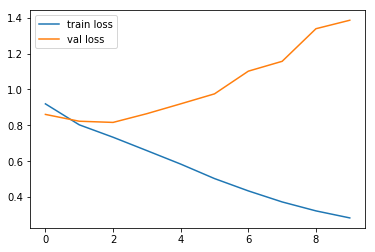

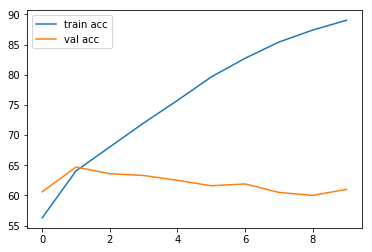

In [77]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()

## kernel=3, feature_maps=200, n_channels2=100,drop_out =0.2,weight_decay=0.000001

In [74]:
model = CNN2(300, 3, words_to_load+2,200,100,0.2).cuda()
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005,weight_decay=0.000001)
print(model)

m_save, loss_hists,acc_hist = training(model,criterion,optimizer,"model_cnn14",10)

CNN2(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
  (conv2): Conv2d(200, 100, kernel_size=(5, 1), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=(10, 1), stride=(10, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
  (dp1): Dropout(p=0.2)
)


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Phase: train, epoch loss: 0.9047, accuracy: 57.3710
Epoch: 0, Phase: validate, epoch loss: 0.8261, accuracy: 62.2000


/home/cvh255/pyenv/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1, Phase: train, epoch loss: 0.7988, accuracy: 64.4350
Epoch: 1, Phase: validate, epoch loss: 0.7971, accuracy: 64.5000
Epoch: 2, Phase: train, epoch loss: 0.7399, accuracy: 67.9640
Epoch: 2, Phase: validate, epoch loss: 0.7948, accuracy: 63.7000
Epoch: 3, Phase: train, epoch loss: 0.6893, accuracy: 70.5660
Epoch: 3, Phase: validate, epoch loss: 0.7904, accuracy: 65.8000
Epoch: 4, Phase: train, epoch loss: 0.6429, accuracy: 72.9190
Epoch: 4, Phase: validate, epoch loss: 0.8078, accuracy: 67.0000
Epoch: 5, Phase: train, epoch loss: 0.5950, accuracy: 75.1510
Epoch: 5, Phase: validate, epoch loss: 0.7886, accuracy: 67.4000
Epoch: 6, Phase: train, epoch loss: 0.5491, accuracy: 77.4380
Epoch: 6, Phase: validate, epoch loss: 0.8373, accuracy: 65.6000
Epoch: 7, Phase: train, epoch loss: 0.5020, accuracy: 79.6230
Epoch: 7, Phase: validate, epoch loss: 0.9046, accuracy: 64.8000
Epoch: 8, Phase: train, epoch loss: 0.4601, accuracy: 81.4960
Epoch: 8, Phase: validate, epoch loss: 0.9578, ac

30382903


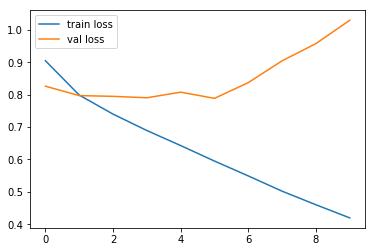

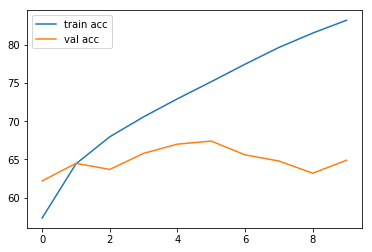

In [75]:
print(count_parameters(model))
import matplotlib.pyplot as plt
plt.plot(loss_hists['train'],label="train loss")
plt.plot(loss_hists['validate'],label="val loss")
plt.legend()
plt.show()

plt.plot(acc_hist['train'],label="train acc")
plt.plot(acc_hist['validate'],label="val acc")
plt.legend()
plt.show()